<a href="https://colab.research.google.com/github/Ved204/CP468-Facial-Recognition/blob/main/CP468_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Facial Emotion Recognition

Project Configuration

In [40]:
# Import Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import cv2
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.python.keras.utils.np_utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.layers import Input,Activation,Add, BatchNormalization, MaxPool2D
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

In [2]:
# Mount Drive
from google.colab import drive
import os

drive.mount('/content/drive')
kaggle_json_path = '/content/drive/MyDrive/CP468 Project/kaggle.json'
# %cd '/content/drive/MyDrive/CP468 Project/dataset/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install Dataset
# !pip install kaggle
# ! mkdir ~/.kaggle
# ! cp {kaggle_json_path} ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download -d shuvoalok/ck-dataset
# ! unzip ck-dataset.zip

Pre-Process Data

In [41]:
# Define Variables to read folder names as variables
dataset_folder = '/content/drive/MyDrive/CP468 Project/dataset/input/'
sub_folders=os.listdir(dataset_folder)

i=0
last=[]
images=[]
labels=[]
original_labels = []
temp = sub_folders

In [ ]:
# Define Labels for emotions (consolidate into 3 classes)
# positive : 0, negative : 1, neutral : 2
# positive = ['happy', 'surprise']
# negative = ['anger','sadness']
# neutral = ['contempt', 'disgust', 'fear']

for sub_folder in sub_folders:
  sub_folder_index = temp.index(sub_folder)
  label = sub_folder_index

  # Define labels basis use case.
  if  label in [4, 6]:
    new_label=0
  elif label in [0,5]:
    new_label=1
  else:
    new_label=2

  path = os.path.join(dataset_folder, sub_folder)
  sub_folder_images= os.listdir(path)

  # Read images in the sub folder, one at a time
  for image in sub_folder_images:
    image_path = path+'/'+image
    print(image_path+"\t"+str(new_label))
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image= cv2.resize(image,(48,48))
    images.append(image)
    labels.append(new_label)
    original_labels.append(label)
    i+=1
  last.append(i)

In [43]:
# Preprocess Data
images_x = np.array(images)
labels_y = np.array(labels)
images_x = images_x/255

# Encode Labels
num_of_classes = 3
labels_y_encoded = tf.keras.utils.to_categorical(labels_y,num_classes=num_of_classes)

In [44]:
# Split Dataset in 75% for Training and 25% for Testing
X_train, X_test, Y_train, Y_test= train_test_split(images_x, labels_y_encoded,test_size=0.25, random_state=10)

Data Analysis

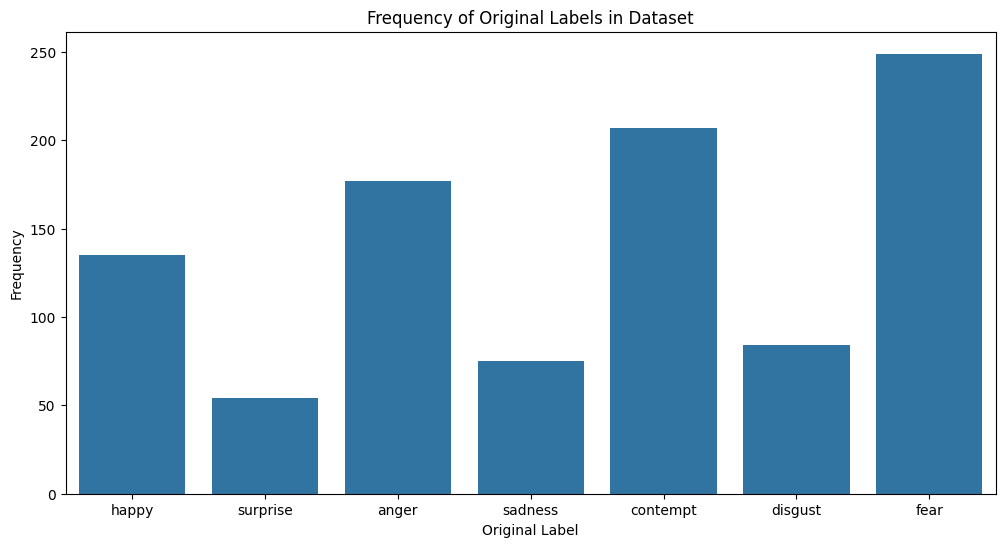

In [45]:
# Map original numerical labels to string labels
original_label_mapping = {
    0: 'happy', 1: 'surprise', 2: 'anger', 3: 'sadness', 4: 'contempt', 5: 'disgust', 6: 'fear'
}
original_labels_mapped = [original_label_mapping[label] for label in original_labels]

# Create a DataFrame from the original labels
original_labels_df = pd.DataFrame({'original_label': original_labels_mapped})

# Plot the frequency of original labels
plt.figure(figsize=(12, 6))
sns.countplot(x='original_label', data=original_labels_df, order=['happy', 'surprise', 'anger', 'sadness', 'contempt', 'disgust', 'fear'])
plt.title('Frequency of Original Labels in Dataset')
plt.xlabel('Original Label')
plt.ylabel('Frequency')
plt.show()

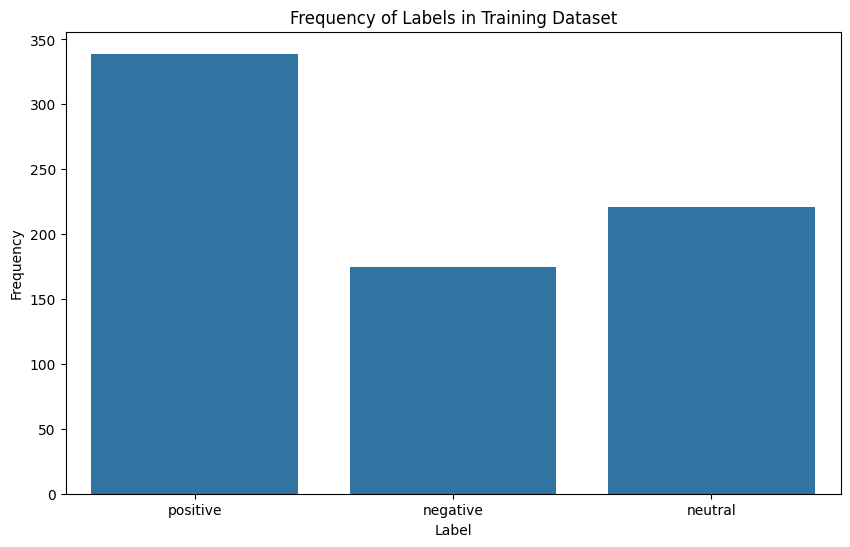

In [46]:
# Plotting Frequency of Labels in training dataset

Y_train_labels = np.argmax(Y_train, axis=1)

# Map numerical labels to string labels
label_mapping = {0: 'positive', 1: 'negative', 2: 'neutral'}
Y_train_labels_mapped = [label_mapping[label] for label in Y_train_labels]

# Create a DataFrame from the training labels
train_df = pd.DataFrame({'label': Y_train_labels_mapped})

# Plot the frequency of labels
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=train_df, order=['positive', 'negative', 'neutral'])
plt.title('Frequency of Labels in Training Dataset')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

In [47]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Function to load images from each subfolder
def load_images_from_folder(folder, num_images=3):
    images = []
    for filename in os.listdir(folder)[:num_images]:  # Load only the first `num_images` images
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path) and img_path.endswith('.png'):
            img = mpimg.imread(img_path)
            images.append(img)
    return images

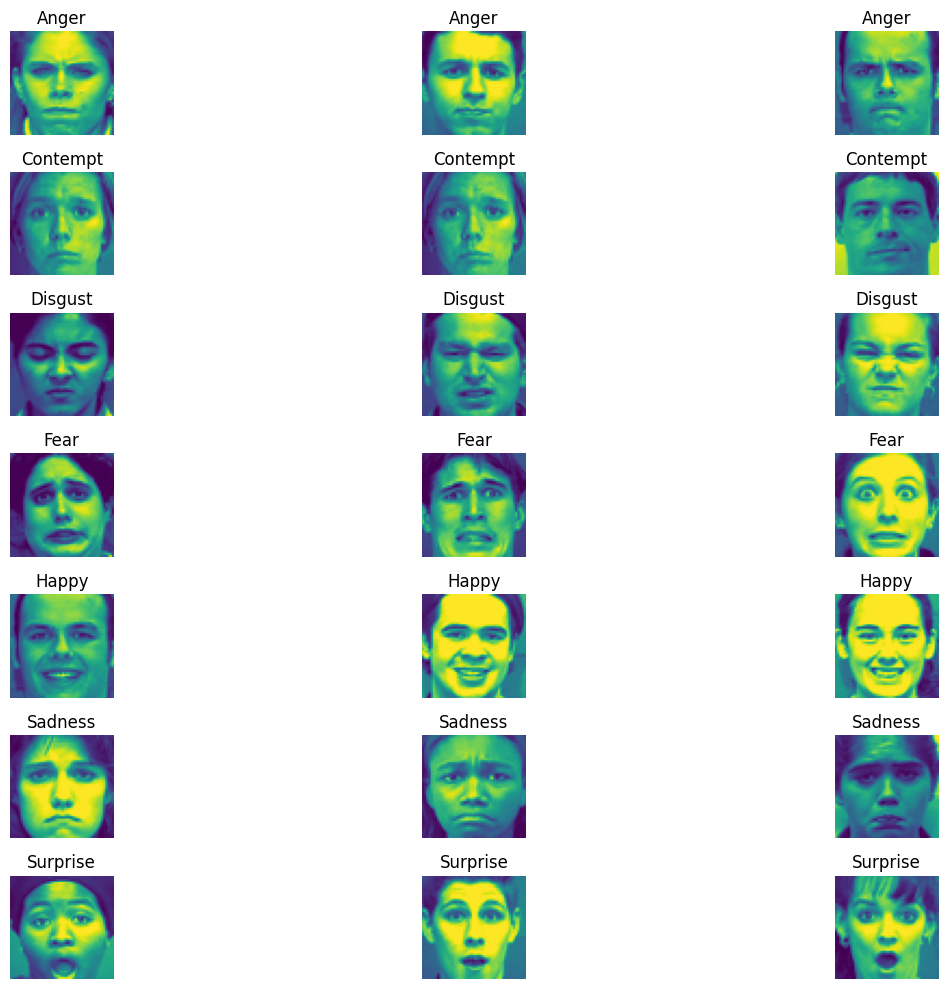

In [48]:
# Load a few images from each emotion subfolder
emotion_images = {emotion: load_images_from_folder(os.path.join(dataset_folder, emotion)) for emotion in sub_folders}

# Display the images in a grid
num_images_per_row = 3
plt.figure(figsize=(15, 10))

for i, (emotion, images) in enumerate(emotion_images.items()):
    for j, img in enumerate(images):
        plt.subplot(len(sub_folders), num_images_per_row, i * num_images_per_row + j + 1)
        plt.imshow(img)
        plt.title(f"{emotion.capitalize()}")
        plt.axis('off')

plt.tight_layout()
plt.show()

Build CNN Architecture

In [49]:
# CNN Architecture
input = Input(shape = (48,48,1))
conv1 = Conv2D(32,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(input)
conv1 = Dropout(0.1)(conv1)
conv1 = Activation('relu')(conv1)
pool1 = MaxPooling2D(pool_size = (2,2)) (conv1)
conv2 = Conv2D(64,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool1)
conv2 = Dropout(0.1)(conv2)
conv2 = Activation('relu')(conv2)
pool2 = MaxPooling2D(pool_size = (2,2)) (conv2)
conv3 = Conv2D(128,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool2)
conv3 = Dropout(0.1)(conv3)
conv3 = Activation('relu')(conv3)
pool3 = MaxPooling2D(pool_size = (2,2)) (conv3)
conv4 = Conv2D(256,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool3)
conv4 = Dropout(0.1)(conv4)
conv4 = Activation('relu')(conv4)
pool4 = MaxPooling2D(pool_size = (2,2)) (conv4)
flatten = Flatten()(pool4)
dense_1 = Dense(128,activation='relu')(flatten)
drop_1 = Dropout(0.2)(dense_1)
output = Dense(3,activation="sigmoid")(drop_1)

# Model compile
model = Model(inputs=input,outputs=output)
model.compile(optimizer="adam", loss=["categorical_crossentropy"], metrics=['accuracy'])
model.summary()

# Configure Model Checkpoint
fle_s='/content/drive/MyDrive/CP468 Project/dataset/output/emotion_model.h5'
checkpointer = ModelCheckpoint(fle_s, monitor='loss',verbose=1,save_best_only=True,
                               save_weights_only=False, mode='auto',save_freq='epoch')
callback_list=[checkpointer]

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 dropout_15 (Dropout)        (None, 48, 48, 32)        0         
                                                                 
 activation_12 (Activation)  (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 24, 24, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 64)        18496     
                                                           

Model Training

In [50]:
save = model.fit(X_train,Y_train,batch_size=32,validation_data=(X_test,Y_test),epochs=50,callbacks=[callback_list])

Epoch 1/50
19/23 [=======================>......] - ETA: 0s - loss: 1.3088 - accuracy: 0.4688
Epoch 1: loss improved from inf to 1.29941, saving model to /content/drive/MyDrive/CP468 Project/dataset/output/emotion_model.h5
23/23 [==============================] - 3s 51ms/step - loss: 1.2994 - accuracy: 0.4517 - val_loss: 1.2037 - val_accuracy: 0.4756
Epoch 2/50
22/23 [===========================>..] - ETA: 0s - loss: 1.1837 - accuracy: 0.4531
Epoch 2: loss improved from 1.29941 to 1.17545, saving model to /content/drive/MyDrive/CP468 Project/dataset/output/emotion_model.h5
23/23 [==============================] - 0s 15ms/step - loss: 1.1755 - accuracy: 0.4612 - val_loss: 1.1038 - val_accuracy: 0.4756
Epoch 3/50
22/23 [===========================>..] - ETA: 0s - loss: 1.1095 - accuracy: 0.4631
Epoch 3: loss improved from 1.17545 to 1.10794, saving model to /content/drive/MyDrive/CP468 Project/dataset/output/emotion_model.h5
23/23 [==============================] - 0s 12ms/step - loss: 1

Analyze and Plot Results

Text(0.5, 0.92, 'Lineplots showing loss and accuracy of CNN model by epochs')

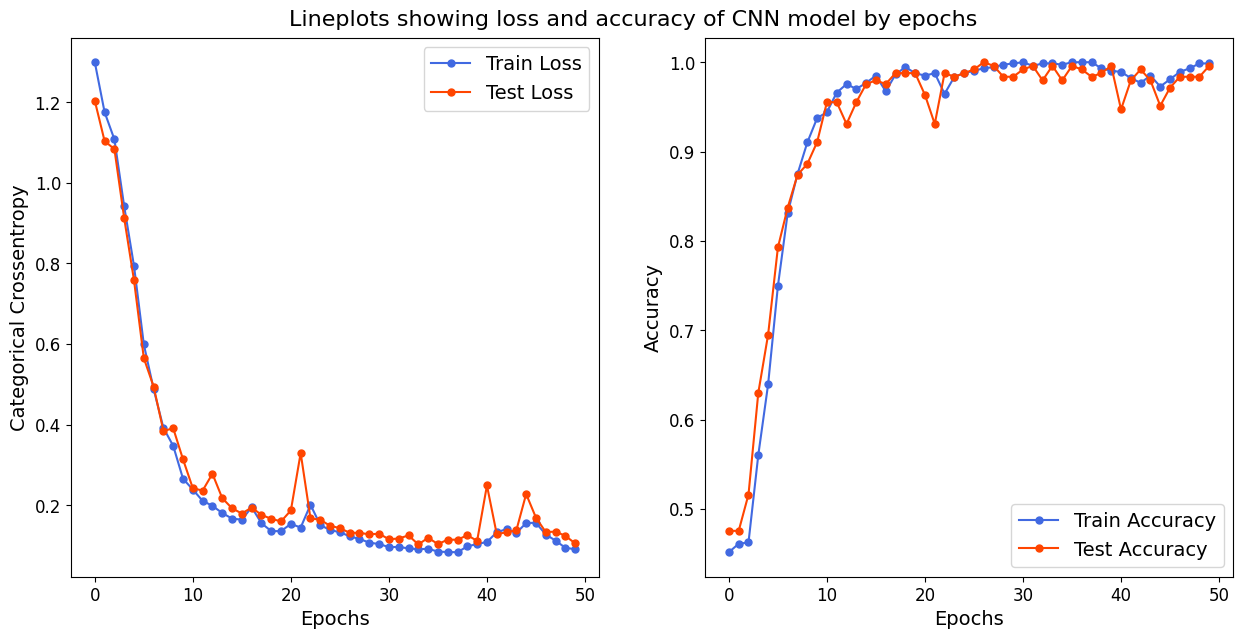

In [51]:
# Accuracy and Loss Graph
train_loss = save.history['loss']
test_loss = save.history['val_loss']
train_accuracy = save.history['accuracy']
test_accuracy = save.history['val_accuracy']

# Plotting a line chart to visualize the loss and accuracy values by epochs.
fig, ax = plt.subplots(ncols=2, figsize=(15,7))
ax = ax.ravel()
ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)
ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)


Original Output: happy
1/1 [==============================] - 0s 17ms/step
Predicted Output: positive


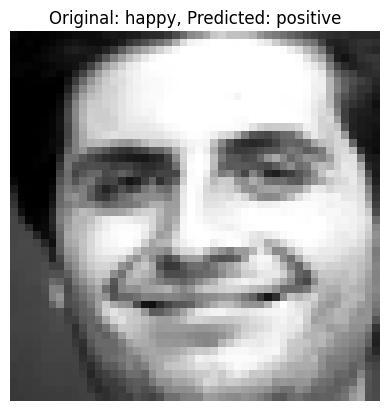

In [54]:
# Test with Random Image
image_index = random.randint(0, len(X_test) - 1)
print("Original Output:", original_label_mapping[np.argmax(Y_test[image_index])])
pred = model.predict(X_test[image_index].reshape(1, 48, 48, 1))
prediction_label = label_mapping[pred.argmax()]
print("Predicted Output:", prediction_label)

# Display the image
plt.imshow(X_test[image_index].reshape(48, 48), cmap='gray')
plt.title(f"Original: {original_label_mapping[np.argmax(Y_test[image_index])]}, Predicted: {prediction_label}")
plt.axis('off')
plt.show()
